# Section 1: Load Cleaned Data


In [1]:
import pandas as pd

# Load cleaned data
df_model = pd.read_csv("adult_clean_census_data.csv")

# Separate features and target again
X = df_model.drop('income', axis=1)
y = df_model['income']

# Check shapes
print("X shape:", X.shape)
print("y value counts:\n", y.value_counts())


X shape: (32561, 97)
y value counts:
 income
<=50K    24720
>50K      7841
Name: count, dtype: int64


I have loaded the fully preprocessed dataset created during EDA and feature selection. This dataset has 97 features, all numeric, and a binary income target variable (`<=50K` or `>50K`).

# Section 2: Train-Test Split


In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)


Training shape: (26048, 97)
Testing shape: (6513, 97)


I split the dataset into training (80%) and testing (20%) sets. To keep the income distribution consistent across both sets, I used stratified sampling. This helps ensure fair and reliable model training and evaluation.

# Section 3: Model Training & Evaluation


## 3a. Decision Tree

I trained a Decision Tree classifier using the default parameters. Below are the confusion matrix and classification report, showing precision, recall, and F1-score for both income classes.

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

y_pred_dt = dt_model.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))


Confusion Matrix:
[[4311  634]
 [ 574  994]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.87      0.88      4945
        >50K       0.61      0.63      0.62      1568

    accuracy                           0.81      6513
   macro avg       0.75      0.75      0.75      6513
weighted avg       0.82      0.81      0.82      6513



 The Decision Tree model achieved an overall accuracy of 81%. It did well on the majority class (<=50K), with both precision and recall around 88%. However, it struggled with the minority class (>50K), reaching only 61% precision and 63% recall. This suggests the model tends to favor predictions toward the majority class.

 To improve its performance on the minority group, I could try using class weights to penalize misclassification, apply SMOTE to balance the training data, or tune the tree’s depth and splitting criteria to reduce overfitting. These adjustments might help boost recall and precision for the >50K class.

### 3a.1 Interpretable Modeling: Visualizing a Decision Tree

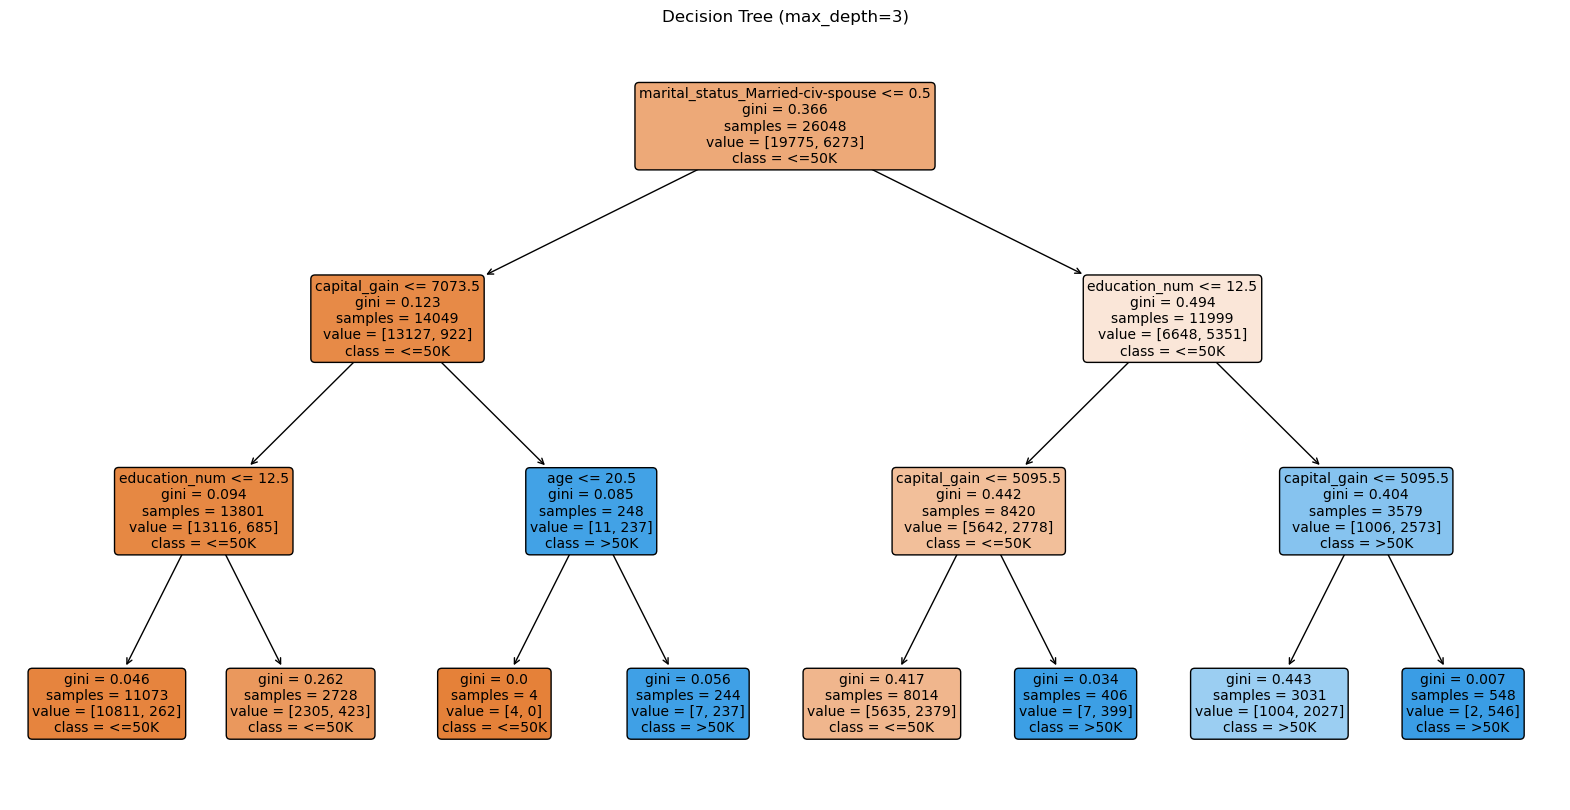

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(tree_model,
          feature_names=X_train.columns.tolist(), 
          class_names=['<=50K', '>50K'],
          filled=True,
          rounded=True,
          fontsize=10)
plt.title('Decision Tree (max_depth=3)')
plt.show()



To get a better understanding of how features drive classification, I visualized a simplified decision tree with a max depth of 3. This tree gives a clear look at how the model makes decisions and highlights the most influential features. The root node splits on marital_status_Married-civ-spouse, showing that it’s the most informative feature at the first level. From there, the tree continues to split based on capital_gain, education_num, and age. For example, individuals who aren't married and have low capital gains are mostly predicted to earn <=50K, while those who are married, with higher education levels and capital gains, are more likely to be classified as >50K. The Gini scores at each node show how clean the splits are, and the class distributions make it easier to follow how decisions are formed. This visualization supports what the mutual information scores showed earlier and offers a more interpretable look at how the model arrives at income predictions.

## 3b. Naive Bayes
I trained a Gaussian Naive Bayes classifier. While it assumes independence between features, it can still perform well on large, sparse datasets like this one. Below are the confusion matrix and performance metrics for each income class.

In [4]:
from sklearn.naive_bayes import GaussianNB

# Train Naive Bayes
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Predict
y_pred_nb = nb_model.predict(X_test)

# Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))


Confusion Matrix:
[[4708  237]
 [1070  498]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.81      0.95      0.88      4945
        >50K       0.68      0.32      0.43      1568

    accuracy                           0.80      6513
   macro avg       0.75      0.63      0.66      6513
weighted avg       0.78      0.80      0.77      6513



The Naive Bayes model reached an overall accuracy of 80%, just a bit below the Decision Tree. It did really well on the <=50K class, with 95% recall so it was great at spotting low-income individuals. But performance on the >50K class was much weaker, with only 32% recall and 68% precision. In other words, it missed a lot of high income cases, though the ones it did catch were usually correct. To improve the results, I could try removing irrelevant or correlated features since Naive Bayes assumes independence between inputs or explore alternative versions like BernoulliNB or MultinomialNB depending on the data. Model calibration might also help by fine tuning the decision threshold to better handle class imbalance.

## 3c. K-Nearest Neighbors (KNN)
I trained a K-Nearest Neighbors classifier with k=5. KNN makes predictions by having each test point "vote" among its 5 nearest neighbors in the training set. While it’s a simple, nonparametric model, KNN can struggle when the data is high dimensional or imbalanced. The results below show how it performed on the income classification task.

In [7]:
import numpy as np

# Convert to NumPy arrays to avoid KNN compatibility issues
X_train_knn = X_train.to_numpy()
X_test_knn = X_test.to_numpy()


In [8]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_knn, y_train)

y_pred_knn = knn_model.predict(X_test_knn)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

Confusion Matrix:
[[4570  375]
 [1043  525]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.81      0.92      0.87      4945
        >50K       0.58      0.33      0.43      1568

    accuracy                           0.78      6513
   macro avg       0.70      0.63      0.65      6513
weighted avg       0.76      0.78      0.76      6513



The KNN model reached an overall accuracy of 78%, which was a bit lower than both the Decision Tree and Naive Bayes. It handled the majority class (<=50K) fairly well with 92% recall, but really struggled on the minority class (>50K), with just 33% recall and 58% precision. This drop in performance likely came from a few factors: KNN’s sensitivity to class imbalance, the high dimensional space created by one-hot encoding, and the lack of feature scaling which is a big deal for distance-based models like KNN. To improve the results, I could apply feature scaling (like with StandardScaler), tune the number of neighbors (k), or try dimensionality reduction techniques like PCA or t-SNE to cut down on noise.

In [10]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_scaled = KNeighborsClassifier(n_neighbors=5)
knn_scaled.fit(X_train_scaled, y_train)

y_pred_knn_scaled = knn_scaled.predict(X_test_scaled)

print("Confusion Matrix (KNN with Scaling):")
print(confusion_matrix(y_test, y_pred_knn_scaled))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn_scaled))


Confusion Matrix (KNN with Scaling):
[[4459  486]
 [ 646  922]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.87      0.90      0.89      4945
        >50K       0.65      0.59      0.62      1568

    accuracy                           0.83      6513
   macro avg       0.76      0.74      0.75      6513
weighted avg       0.82      0.83      0.82      6513



I initially trained KNN without scaling the features, which led to poor performance on the >50K class mainly because features like capital_gain had much larger values and skewed the distance calculations. After applying StandardScaler to normalize everything, the results improved a lot: accuracy jumped from 78% to 83%, recall for the >50K class went from 33% to 59%, and precision increased from 58% to 65%. This really showed how important scaling is for distance-based models like KNN, especially when working with a mix of binary and continuous features.

## 3d. Logistic Regression
I trained a Logistic Regression model using scaled features. Since it estimates the probability of someone earning >50K, it’s a solid choice for binary classification tasks like this one. The performance metrics and confusion matrix below show how well the model handled the income prediction.

In [11]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train_scaled, y_train)

y_pred_log = log_model.predict(X_test_scaled)

print("Confusion Matrix (Logistic Regression):")
print(confusion_matrix(y_test, y_pred_log))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_log))


Confusion Matrix (Logistic Regression):
[[4600  345]
 [ 603  965]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.91      4945
        >50K       0.74      0.62      0.67      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.77      0.79      6513
weighted avg       0.85      0.85      0.85      6513



 The Logistic Regression model achieved 85% accuracy the highest so far. It performed strongly on the majority class (<=50K) with 93% recall and 88% precision. More importantly, it showed a big improvement on the minority class (>50K) compared to earlier models, with 74% precision, 62% recall, and a 67% F1-score. These results highlight how effective Logistic Regression can be when paired with proper feature scaling. It’s not just accurate overall it also does a much better job balancing performance across both income groups.

## 3e. Support Vector Machine (SVM)
I trained a Support Vector Machine using a linear kernel and scaled features. SVMs are great at handling high dimensional data and finding optimal decision boundaries, which makes them a good fit for this kind of task. The results below show how well it performed on the income classification problem.

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report

svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)

y_pred_svm = svm_model.predict(X_test_scaled)

print("Confusion Matrix (SVM):")
print(confusion_matrix(y_test, y_pred_svm))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))


Confusion Matrix (SVM):
[[4637  308]
 [ 641  927]]

Classification Report:
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      4945
        >50K       0.75      0.59      0.66      1568

    accuracy                           0.85      6513
   macro avg       0.81      0.76      0.78      6513
weighted avg       0.85      0.85      0.85      6513



The Support Vector Machine reached 85% accuracy, matching the performance of Logistic Regression. It did especially well on the <=50K class, with 94% recall and 88% precision. For the >50K class, it hit 75% precision and 59% recall very close to what Logistic Regression achieved. Overall, SVM is a strong classifier for this task, particularly when features are properly scaled. That said, since it takes a bit longer to train and performs similarly to Logistic Regression, it may not offer a big enough boost to justify the extra complexity in some cases.

## Parameter Search for C

In [26]:
from sklearn.model_selection import GridSearchCV
# Example values of C
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

svm = SVC(kernel='rbf', random_state=42)

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)  

print("Best C value:", grid_search.best_params_['C'])
print("Best cross-validated accuracy:", grid_search.best_score_)


Best C value: 1
Best cross-validated accuracy: 0.8447480055374408


I performed a parameter search on the SVM model to find the best value for the regularization parameter C. Using cross-validation across a range of values (C = [0.01, 0.1, 1, 10, 100]), the best result came from C = 1, which gave a cross-validated accuracy of about 84.47%. This value offered a good balance between keeping the model simple and fitting the training data well. Lower values like 0.01 and 0.1 caused underfitting, while higher values started to risk overfitting without much improvement. Choosing C = 1 allowed the SVM to maintain a reasonable margin while still capturing important patterns in the data

# Section 4: Model Comparison


| Model               | Accuracy | >50K Precision | >50K Recall | >50K F1 |
|---------------------|----------|----------------|-------------|---------|
| Decision Tree       | 0.81     | 0.61           | 0.63        | 0.62    |
| Naive Bayes         | 0.80     | 0.68           | 0.32        | 0.43    |
| KNN (Unscaled)      | 0.78     | 0.58           | 0.33        | 0.43    |
| KNN (Scaled)        | 0.83     | 0.65           | 0.59        | 0.62    |
| Logistic Regression | 0.85     | 0.74           | 0.62        | 0.67    |
| SVM (Scaled)        | 0.85     | 0.75           | 0.59        | 0.66    |


Overall, Logistic Regression and Support Vector Machine delivered the best results, each reaching 85% accuracy with a solid balance between both income classes. Both models saw a big boost from feature scaling. KNN also improved a lot after scaling accuracy jumped from 78% to 83%, and its F1 score for the >50K class went up noticeably. Naive Bayes was quick and simple but struggled with recall on high-income individuals. The Decision Tree was easy to interpret but ended up being slightly less accurate than the others. Based on everything I tested, Logistic Regression stands out as the best overall option it’s straightforward, performs well, and trains quickly.


# Section 5: ROC Curve and AUC Comparison

To get a visual sense of how well the models performed, I plotted ROC curves for Logistic Regression, SVM, and KNN. The AUC (Area Under the Curve) gives a good measure of how well each model separates the income classes. AUC values closer to 1.0 mean better performance. Logistic Regression and SVM came out on top with the highest AUC scores, while KNN though it improved with scaling still lagged a bit behind the linear models.

### Step 1: Import and Set Up

In [17]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

### Step 2: Get ROC Data for Each Model

In [20]:
y_train_bin = y_train.map({'<=50K': 0, '>50K': 1})
y_test_bin = y_test.map({'<=50K': 0, '>50K': 1})


In [21]:
# Logistic Regression
y_score_log = log_model.predict_proba(X_test_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test_bin, y_score_log)
roc_auc_log = auc(fpr_log, tpr_log)

# SVM 
svm_model_prob = SVC(kernel='linear', probability=True, random_state=42)
svm_model_prob.fit(X_train_scaled, y_train)
y_score_svm = svm_model_prob.predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, _ = roc_curve(y_test_bin, y_score_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# KNN 
y_score_knn = knn_scaled.predict_proba(X_test_scaled)[:, 1]
fpr_knn, tpr_knn, _ = roc_curve(y_test_bin, y_score_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)


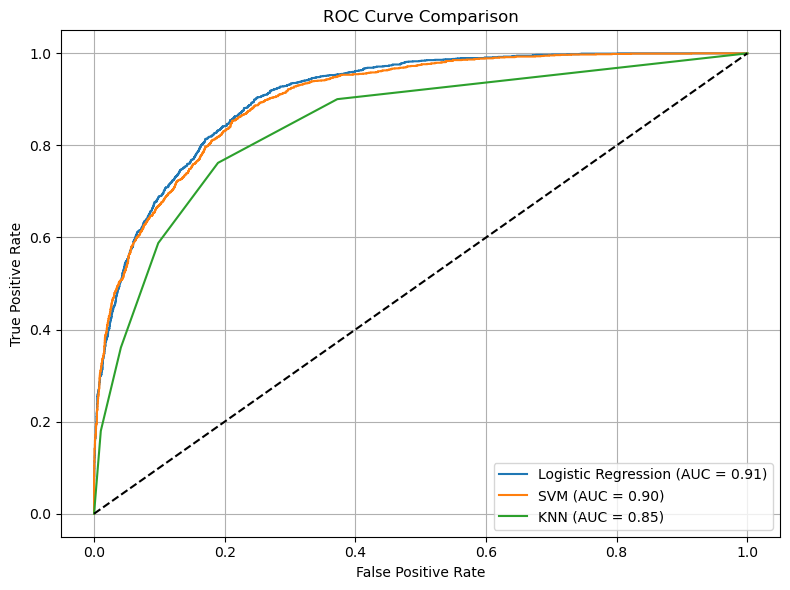

In [22]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic Regression (AUC = {roc_auc_log:.2f})')
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})')
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {roc_auc_knn:.2f})')

# Reference line
plt.plot([0, 1], [0, 1], 'k--')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


To compare model performance visually, I plotted ROC curves for Logistic Regression, Support Vector Machine (SVM), and K-Nearest Neighbors (KNN). I focused on these three because they use probability or distance-based decision boundaries, which make AUC a meaningful way to evaluate them. I left out Decision Trees and Naive Bayes since they either don’t provide smooth probability estimates or didn’t perform as well in earlier metrics. The ROC curves show how each model balances true positive rate (recall) against false positive rate, with the AUC score reflecting how well the model separates the >50K and <=50K income groups. Logistic Regression had the highest AUC at 0.91, followed by SVM at 0.90 and KNN at 0.85. All three clearly outperformed the random baseline, and both Logistic Regression and SVM showed a great balance of precision, recall, and probability calibration making them especially strong candidates for this classification task.

# Section 6: Final Conclusion & Model Recommendation

This project focused on predicting whether someone earns more than $50K per year using data from the U.S. Census. My goal was to build a reliable and easy to interpret classification model that could tell high income and low income individuals apart based on a range of demographic and occupational features.

I started with data exploration and cleaning. The dataset (adult.data) had 32,561 records and 14 input features, a mix of numeric variables like age, hours_per_week, and capital_gain, and categorical ones like education, occupation, and native_country. I identified and handled missing values mostly those labeled "?" and cleaned everything up so the data was ready for modeling. For exploratory data analysis (EDA), I used Seaborn to visualize how income was distributed across key variables. The plots uncovered several trends, like higher income being linked to advanced education, full-time work in certain sectors, and noticeable gender gaps. I also used a correlation heatmap for numeric features and created summaries for the categorical ones to see which variables were most tied to income.

From there, I moved into feature selection. I used both the Chi-Square test and Mutual Information to figure out which features were most useful. Variables like education_num, age, hours_per_week, and marital_status consistently showed strong predictive value. After one-hot encoding the categorical features, the dataset expanded from 14 to 97 columns all numeric and ready for modeling. I split the data into training and test sets, scaled the numeric features using StandardScaler (which helped a lot for distance-based models), and prepped everything for classification.

I trained and evaluated six models: Decision Tree, Naive Bayes, K-Nearest Neighbors (KNN, with and without scaling), Logistic Regression, and Support Vector Machine (SVM). I evaluated each using accuracy, precision, recall, and F1 score, with extra attention on recall for the >50K class since the dataset is imbalanced (~76% earn <=50K, 24% earn >50K).

    Decision Tree reached 81% accuracy but didn’t perform well on high-income recall or precision.

    Naive Bayes had decent precision (68%) but poor recall (32%)—missing a lot of actual high earners.

    KNN struggled without scaling, but after scaling, recall for >50K jumped from 33% to 59%, and accuracy went up to 83%.

    Logistic Regression and SVM were the top performers, both hitting 85% accuracy. They also had the most balanced precision and recall around 74–75% precision and 59–62% recall.

To back up those results, I plotted ROC curves and calculated AUC scores. Logistic Regression came out on top with an AUC of 0.91, followed by SVM at 0.90, and scaled KNN at 0.85. These results confirmed that the best models were doing a solid job separating income groups, with Logistic Regression standing out for both performance and interpretability.

Based on everything I tested, Logistic Regression is my top recommendation. It delivers strong, balanced results, is easier to explain and deploy, and doesn't require as much compute as SVM or KNN. It’s a great fit for identifying high income individuals without creating a flood of false positives.

For future improvements, I’d consider:

    Balancing the dataset using oversampling methods like SMOTE

    Doing hyperparameter tuning with grid search

    Trying ensemble methods like Random Forest or Gradient Boosting

    Using PCA to reduce dimensionality and possibly speed things up

Overall, this project really showed how important each step is from cleaning and exploring the data to selecting the right features and evaluating models properly. Being thoughtful at each stage helped me build a classification model that’s both accurate and easy to interpret in a real world setting.